In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr

from minisom import MiniSom

import detect_and_track as dt

import matplotlib.pyplot as plt
import matplotlib.colors as mc
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Plan

I'm going to re-do my previous analysis. In this case, I'm going to focus again on **ONE MONTH** over all the years (with more years this time). The difference will be that I'll add more variables to better match that Song et al. paper.

We will do the analysis for that one month with a SOM of size 2x2, but also expand that to something like 3x5 to see if we get a sense of "transition" regimes. 

Once done with that month, we should see how it works for another month independently. If the results are similar, maybe it is worth training on one month and testing with another month? 

Also note that we will be using the expanded domain for the SOM analysis. This is based on Julie's hypothesis that there is supporting circulation structure to the west and/or northwest.

In [8]:
MONTH = "MAY"
dloc = Path("/Volumes/Samsung_T5/mcs_tmp/plev")
ufils = sorted(list(dloc.glob(f"conus_plevs_FV_768x1152.U.bilinear.{MONTH}*.nc")))
vfils = sorted(list(dloc.glob(f"conus_plevs_FV_768x1152.V.bilinear.{MONTH}*.nc")))
qfils = sorted(list(dloc.glob(f"conus_plevs_FV_768x1152.Q.bilinear.{MONTH}*.nc")))
pfils = sorted(list(dloc.glob(f"conus_{MONTH}_FV_768x1152.prect.bilinear.*.nc")))
print(f"There are {len(ufils)} U files, {len(vfils)} V files, {len(qfils)} Q files, {len(pfils)} prect files.")
uds = xr.open_mfdataset(ufils, combine='by_coords', decode_times=True)  # note, the files don't have time_bnds, 
# so I'm pretty sure the timestamps will be at the end of the averaging period, NOT CENTERED.
vds = xr.open_mfdataset(vfils, combine='by_coords', decode_times=True)
qds = xr.open_mfdataset(qfils, combine='by_coords', decode_times=True)
pds = xr.open_mfdataset(pfils, combine='by_coords', decode_times=True)


There are 25 U files, 25 V files, 25 Q files, 25 prect files.


In [9]:
lat = pds['lat']
lon = pds['lon']
pdata = pds['PRECT'].load()  # load() forces the data into memory in case it is a dask array

In [11]:
# get the quantiles of prect at each grid point
quants = np.nanquantile(pdata.values, .95, axis=0)
quants_xr = xr.DataArray(quants, dims=["lat","lon"], coords={"lat":lat, "lon":lon})
mask = np.where(pdata >= quants, 1, 0)
mask.shape
# this works well enough. We get a space-dependent mask based on the local quantile value.

(6200, 171, 177)

In [12]:
%%time
m0_labels, m0_nfeatures = dt.pr_labeler(
        pdata, quants, track=True, latitude=None, connect=None
    )

CPU times: user 1.91 s, sys: 576 ms, total: 2.49 s
Wall time: 2.52 s


In [13]:
dt.summarize_events(m0_labels, "amip_may", "simpleblobs")

amip_may simpleblobs: [N_events] = 16.02 ± 5.41, Ntot: 45349.00, [D] = 2.19 ± 5.17, [S] = 10.24 ± 42.56, [Smx] = 18.98 ± 105.19


In [14]:
event_df = dt.get_duration_and_size(m0_labels, rettype='df')

In [15]:

def get_initial_tindex(labels, ev):
    if isinstance(labels, np.ndarray):
        labv = labels
    else:
        labv = labels.values  # converts to numpy array
    for t in range(labv.shape[0]):
        tmp = labv[t,:,:] # temporary time slice
        present_events = set(tmp[tmp != 0]) # uniq events in this time
        if ev in present_events:
            return t
    return None


def initiation_mask(labels):
    """Only keep event labels in the first time slice they appear."""
    list_of_known_events = []
    output = labels.copy()
    ntim = labels.shape[0]  # assume time is first dimension
    for i in range(ntim):
        tmp = labels[i,:,:]
        current_events = np.unique(tmp)
        current_events = current_events[current_events != 0]
        for ce in current_events:
            if ce not in list_of_known_events:
                tmp = np.where(tmp==ce, 1, ce)  # keep points that belong to new event
                list_of_known_events.append(ce)
        output[i,:,:] = np.where(tmp==1, output[i,:,:], 0)  # mask to 0 unless a new event
    return output
    

In [16]:
# here are events labeled only during their initial time
mcs_initial = initiation_mask(m0_labels)
# mcs_initial_selection = m0_labels[np.where(mcs_initial.max(dim=('lat', 'lon'))>0, True, False), :, :] # this is how we need to select vars

In [17]:
mcs_initial_da = xr.DataArray(mcs_initial, dims=pdata.dims, coords=pdata.coords)
# print(mcs_initial_da)

<xarray.DataArray (time: 6200, lat: 171, lon: 177)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0

## SOM Analysis, Part II

The way Song et al. perform the analysis is by making long feature vectors of the variables. This is actually similar to how \cite{Chattopadhyay:2008} do it, too. 

To make it clear, the data that is used to "train" the SOM is in the standard (observations, features) format. For our case, each "observation" is a time when MCS initiation within our specified region occurs. Our "feature vector" is constructed by taking the full spatial array of the variables to be used. In this toy example we just have two variables, v and q. So the each feature vector will be ($2 \times nlat \times nlon$). 

In [23]:
# this will work if using the whole variable and THEN extract MCS initiation
def scaler(variable, dim='time', remove_mean=True, standardize=True):
    if remove_mean:
        tmp = variable - variable.mean(dim=dim)
    else:
        tmp = variable
    if standardize:
        tmp = tmp / variable.std(dim=dim)
    return tmp.squeeze()  # squeeze just in case there are any singleton dims

In [26]:
lons, lats = np.meshgrid(lon, lat)
lons_da = xr.DataArray(lons.T, dims=("lon","lat"), coords={"lon":lon, "lat":lat})
lats_da = xr.DataArray(lats.T, dims=("lon","lat"), coords={"lon":lon, "lat":lat})
lons_full = lons_da.broadcast_like(mcs_initial_da)
lats_full = lats_da.broadcast_like(mcs_initial_da)

# ONLY LOOK FOR INITIATION IN A BOX
mcs_small = np.where(((lons_full >= 360-105) & (lons_full <= 360-90)) & ((lats_full >= 15) & (lats_full <= 50)),  mcs_initial_da, 0)
mcs_small.shape

(6200, 171, 177)

In [27]:
# isolate initiation time, when MCS initiation in the smaller box
mcs_small = xr.DataArray(mcs_small, dims=pdata.dims, coords=pdata.coords)

In [21]:
%%time
# prepare variables:
# They are few enough that we just hand code them
print("U")
u = uds['U'].compute()
u925 = u.sel(lev=925)
u500 = u.sel(lev=500)
u200 = u.sel(lev=200)
print("V")
v = vds['V'].compute()
v925 = v.sel(lev=925)
v500 = v.sel(lev=500)
v200 = v.sel(lev=200)
print("Q")
q = qds['Q'].compute()
q925 = q.sel(lev=925)
q500 = q.sel(lev=500)


U
V
Q
CPU times: user 21.8 s, sys: 10.3 s, total: 32.1 s
Wall time: 30.8 s


In [24]:
%%time
# apply scaler:
u925_norm = scaler(u925)
u500_norm = scaler(u500)
u200_norm = scaler(u200)
v925_norm = scaler(v925)
v500_norm = scaler(v500)
v200_norm = scaler(v200)
q925_norm = scaler(q925)
q500_norm = scaler(q500)

CPU times: user 13.1 s, sys: 11 s, total: 24.1 s
Wall time: 28.2 s


In [77]:
def imask_and_stack(da, msk):
    """Select times in `da` when there is an positive value in `msk`.
    Returns a DataArray that has stacked dimension `a` that combines space dims.
    """
    return (da[np.where(msk.max(dim=('lat', 'lon'))>0, True, False), :, :]).stack(a=("lat","lon"))

# extract the initiation times
u925_init_norm = imask_and_stack(u925_norm, mcs_small)
u500_init_norm = imask_and_stack(u500_norm, mcs_small) 
u200_init_norm = imask_and_stack(u200_norm, mcs_small)
v925_init_norm = imask_and_stack(v925_norm, mcs_small)
v500_init_norm = imask_and_stack(v500_norm, mcs_small) 
v200_init_norm = imask_and_stack(v200_norm, mcs_small)
q925_init_norm = imask_and_stack(q925_norm, mcs_small)
q500_init_norm = imask_and_stack(q500_norm, mcs_small) 


spacedim = u925_init_norm['a']

# put it all into a gigantic DataArray (time, a), where now a will be sized (nvars * nlat * nlon)
indata = xr.concat([u925_init_norm, u500_init_norm, u200_init_norm, v925_init_norm, v500_init_norm, v200_init_norm, q925_init_norm, q500_init_norm], dim='a')

indata

<xarray.DataArray 'U' (time: 25, a: 242136)>
array([[-0.26612535, -0.27557147, -0.2691159 , ..., -1.0079238 ,
        -1.0014927 , -0.99970055],
       [ 0.444448  ,  0.4887621 ,  0.5185949 , ..., -0.9284073 ,
        -0.97322524, -1.0158713 ],
       [-0.42233965, -0.36819562, -0.31820938, ...,  0.04872873,
         0.1517223 ,  0.26301646],
       ...,
       [ 0.15108621,  0.05610498, -0.07006347, ..., -0.15059137,
        -0.04128847,  0.11059196],
       [ 1.5576239 ,  1.4423721 ,  1.3565012 , ..., -0.5651755 ,
        -0.6452513 , -0.70046216],
       [ 2.6367753 ,  2.6219852 ,  2.55773   , ..., -0.817567  ,
        -0.8193323 , -0.82331914]], dtype=float32)
Coordinates:
    lev      (a) float32 925.0 925.0 925.0 925.0 ... 500.0 500.0 500.0 500.0
  * time     (time) object 1980-05-06 12:00:00 ... 2004-05-30 03:00:00
  * a        (a) MultiIndex
  - lat      (a) float64 20.07 20.07 20.07 20.07 ... 59.96 59.96 59.96 59.96
  - lon      (a) float64 235.0 235.3 235.6 235.9 ... 289.1 289.4 289.7 290.0

In [67]:
adimension = indata['a']

In [68]:
# Initialization of SOM
som_shape = (2,2)  # this specifies the 2D output shape of the SOM

# make data such that  
som_2x2 = MiniSom(som_shape[0], som_shape[1], indata.shape[-1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

som_2x2.train_batch(indata.values, 1000, verbose=True)

wm_2x2 = som_2x2.win_map(indata.values)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 431.08747678677025


In [83]:
# wm provides the data for each node when it is the "winner" 
# wm[node_i] is a list of arrays
# wm[node_i][j] has size (nVars * nlat * nlon)

# Construct composites by averaging Q, v in each node
NodeComposites = {}
winCounts = {}

variables = ['u925', 'u500', 'u200', 'v925', 'v500', 'v200', 'q925', 'q500']  # MAKE SURE ORDER IS SAME AS IN STACKED VARIABLES!
nvars = len(variables)
nlatlon = len(lat)*len(lon)
for node in wm_2x2:
    atmp = np.array(wm_2x2[node])  # list -> array
    NodeComposites[node] = {}
    winCounts[node] = {}
    for i, x in enumerate(variables):
        s = i*nlatlon
        f = (i+1)*nlatlon
        btmp = np.mean(atmp[:, s:f], axis=0)
        print(f"btmp shape: {btmp.shape}, type: {type(btmp)}")
        NodeComposites[node][x] = xr.DataArray(btmp, dims="a", coords={"a":spacedim}).unstack()
        winCounts[node][x] = atmp.shape[0]

btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: (30267,), type: <class 'numpy.ndarray'>
btmp shape: 

## Composites at each node

We now have NodeComposites, a dictionary holding data at each node. Each node's entry is a dictionary that holds the composite for each variable. We've got a bunch of variables here making it a little daunting to look at everything. 

To keep it simple at first, let's make a 2x2 array of the maps of wind vectors, and then do that for each of the three levels.

In [171]:
def plot_node_composite_quiver(som_shape, nodecomps, uvarname, vvarname):
    fig, ax = plt.subplots(figsize=(12,8), nrows=som_shape[0], ncols=som_shape[1], 
                           subplot_kw={"projection":ccrs.PlateCarree()})
    for i, n in enumerate(nodecomps):
        a = ax[n[0], n[1]]  # keeps the nodes in the correct position regardless of order
        unode = nodecomps[n][uvarname]
        vnode = nodecomps[n][vvarname]
        wlon, elon, slat, nlat = (unode['lon'].min().values.item(), 
                                  unode['lon'].max().values.item(), 
                                  unode['lat'].min().values.item(), 
                                  unode['lat'].max().values.item())
        a.set_extent((wlon, elon, slat, nlat), ccrs.PlateCarree())
        a.coastlines()
        a.add_feature(cfeature.OCEAN, zorder=0)
        a.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
        windspeed = (unode ** 2 + vnode ** 2) ** 0.5
        windspeed.name ='windspeed'
        print(f"WNDSPD: min {windspeed.min().values.item()}, max {windspeed.max().values.item()}")
        lon1 = unode['lon'].values - 360.0  # !! Cartopy really prefers  longitude \in -180:180
        lat1 = unode['lat'].values
        lons, lats = np.meshgrid(unode['lon'], unode['lat'])
        # OPTIONS FOR HOW TO PLOT: quiver, barbs, streamplot
#         a.quiver(lon1, lat1, unode.values, vnode.values, windspeed.values, transform=ccrs.PlateCarree(), 
#                  regrid_shape=(50,50), target_extent=(wlon-360, elon-360, slat, nlat))
#         a.barbs(lon1, lat1, unode.values, vnode.values, regrid_shape=(20,20))
        a.streamplot(lon1, lat1, 
                     unode.values, 
                     vnode.values, 
                     color=windspeed.values,
                     transform=ccrs.PlateCarree(), 
                     density=2)
        a.set_title(f"Node {n}, vectors: ({uvarname}, {vvarname})")
    return fig, ax
        


WNDSPD: min 0.00550334295257926, max 1.8960843086242676
WNDSPD: min 0.006327999755740166, max 1.7289236783981323
WNDSPD: min 0.007474944926798344, max 1.7810206413269043
WNDSPD: min 0.0037463363260030746, max 1.8894113302230835
WNDSPD: min 0.00047869360423646867, max 2.4127092361450195
WNDSPD: min 0.0038679344579577446, max 1.7456564903259277
WNDSPD: min 0.001422744244337082, max 2.5030667781829834
WNDSPD: min 0.0035164388827979565, max 1.9090263843536377
WNDSPD: min 0.005180096719413996, max 1.6132158041000366
WNDSPD: min 0.003405617782846093, max 2.101938009262085
WNDSPD: min 0.0038918177597224712, max 1.8563110828399658
WNDSPD: min 0.0030651402194052935, max 1.5061285495758057


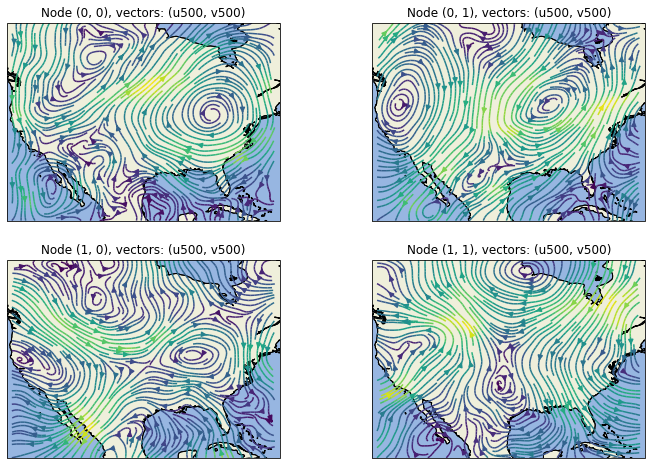

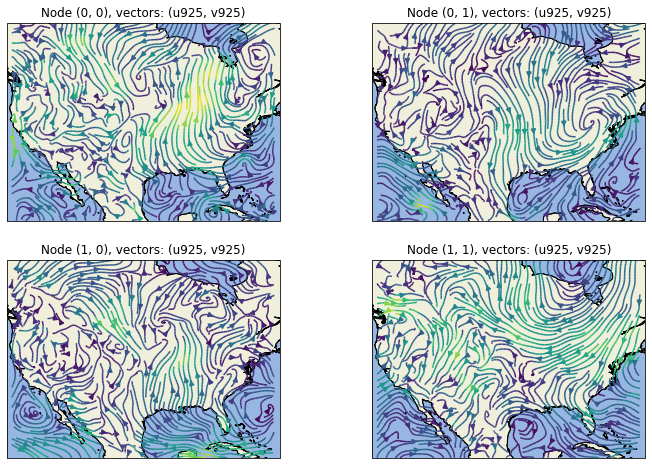

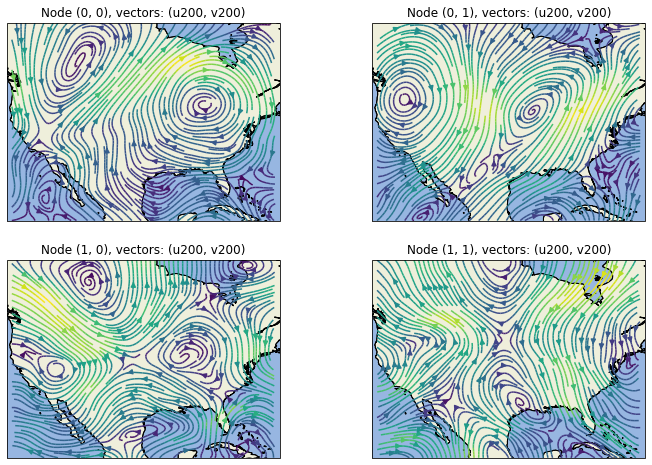

In [172]:
f500, a500 = plot_node_composite_quiver(som_shape, NodeComposites, 'u500', 'v500')
f925, a925 = plot_node_composite_quiver(som_shape, NodeComposites, 'u925', 'v925')
f200, a200 = plot_node_composite_quiver(som_shape, NodeComposites, 'u200', 'v200')

f500.savefig(f"/Users/brianpm/Desktop/som_analysis_wind500_{MONTH}.pdf")
f200.savefig(f"/Users/brianpm/Desktop/som_analysis_wind200_{MONTH}.pdf")
f925.savefig(f"/Users/brianpm/Desktop/som_analysis_wind925_{MONTH}.pdf")




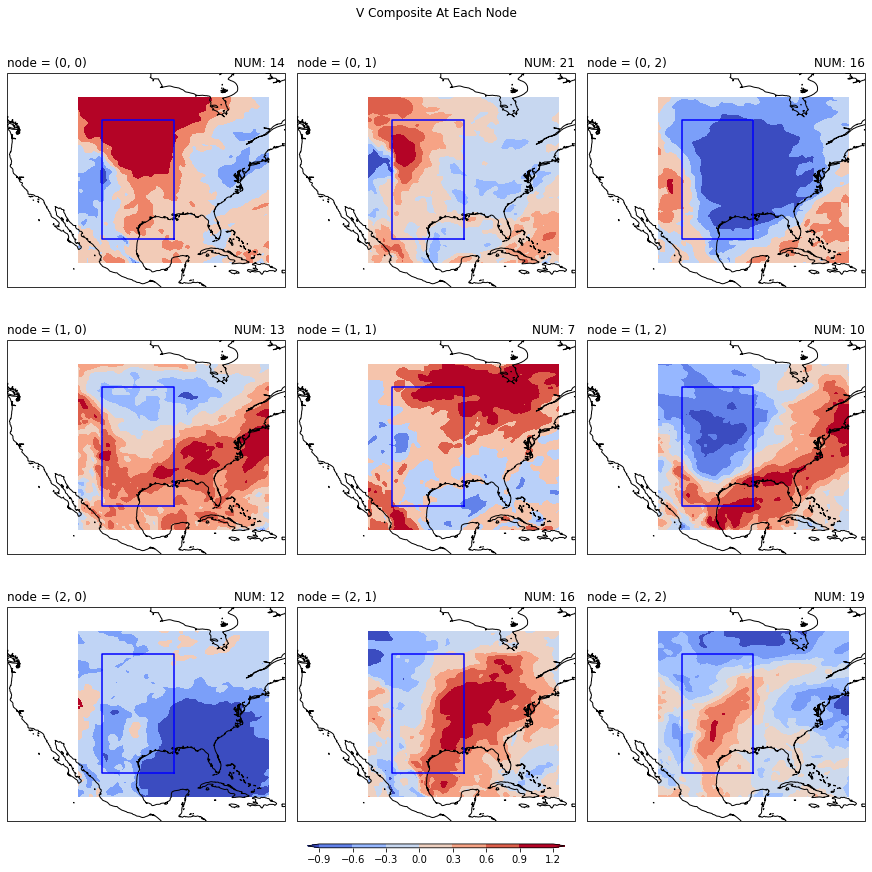

In [134]:
cnorm = mc.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
cmap = "coolwarm"

fig, ax = plt.subplots(figsize=(12,12), nrows=3, ncols=3, subplot_kw={"projection":ccrs.PlateCarree()}, constrained_layout=True)
aa = ax.ravel()
img = []
for i, k in enumerate(vNodeComposite):
    # get the right node location:
    xx=k[0]
    yy=k[1]
    ax[xx,yy].set_extent([-125, -66.5, 15, 60], crs=ccrs.PlateCarree())
    ax[xx,yy].coastlines()
    ax[xx,yy].set_title(f"node = {k}", loc='left')
    ax[xx,yy].set_title(f"NUM: {winCount[k]}", loc='right')
    img.append(ax[xx,yy].contourf(lons, lats, vNodeComposite[k], zorder=0, cmap=cmap, norm=cnorm, extend='both'))
    ax[xx,yy].plot([-90, -105, -105, -90, -90], [25, 25, 50, 50, 25], '-b')
fig.suptitle("V Composite At Each Node")
fig.colorbar(img[-1], ax=ax, shrink=0.3, orientation='horizontal');

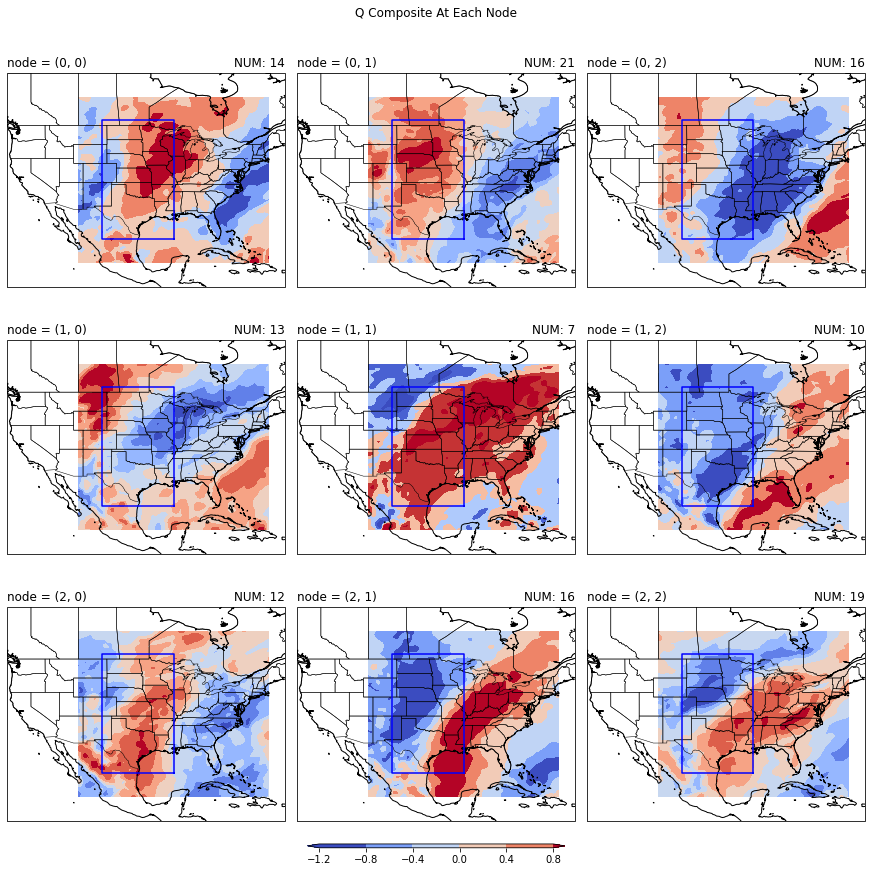

In [138]:
cnorm = mc.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
cmap = "coolwarm"

fig, ax = plt.subplots(figsize=(12,12), nrows=3, ncols=3, subplot_kw={"projection":ccrs.PlateCarree()}, constrained_layout=True)
aa = ax.ravel()
img = []
for i, k in enumerate(vNodeComposite):
    # get the right node location:
    xx=k[0]
    yy=k[1]
    ax[xx,yy].set_extent([-125, -66.5, 15, 60], crs=ccrs.PlateCarree())
    ax[xx,yy].coastlines()
    ax[xx,yy].set_title(f"node = {k}", loc='left')
    ax[xx,yy].set_title(f"NUM: {winCount[k]}", loc='right')
    img.append(ax[xx,yy].contourf(lons, lats, qNodeComposite[k], zorder=0, cmap=cmap, norm=cnorm, extend='both'))
    ax[xx,yy].plot([-90, -105, -105, -90, -90], [25, 25, 50, 50, 25], '-b')
    
[a.add_feature(cfeature.STATES, zorder=1, linewidth=.5, edgecolor='k') for a in aa]

fig.suptitle("Q Composite At Each Node")
fig.colorbar(img[-1], ax=ax, shrink=0.3, orientation='horizontal');

In [119]:
from cartopy.examples.arrows import sample_data
EXx, EXy, EXu, EXv, vector_crs = sample_data(shape=(80, 100))
print(vector_crs)

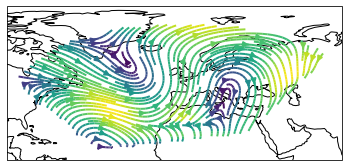

In [128]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-90, 75, 10, 60])
ax.coastlines()

x, y, u, v, vector_crs = sample_data(shape=(80, 100))
magnitude = (u ** 2 + v ** 2) ** 0.5
ax.streamplot(x, y, u, v, transform=vector_crs,
              linewidth=2, density=2, color=magnitude)